In [2]:
import numpy as np
import pandas as pd
# 형태소 분석이나 다른 전처리 과정이 오래걸리기 때문에, 진행 과정을 표시해주는 tqdm Library 사용
from tqdm import tqdm 
import os
from konlpy.tag import Okt

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences # 가장 긴 text의 길이에 맞춰 다른 text들 길이 맞춰줌
from keras.layers import SimpleRNN, Bidirectional, Embedding, GRU, Dense
from keras.models import Sequential

direction = '.'

In [3]:
# colab으로 할 때 필요
from google.colab import drive
drive.mount('/content/gdrive')
direction = '/content/gdrive/My Drive/Colab Notebooks'

Mounted at /content/gdrive


In [4]:
# 데이터의 크기가 커 tokenize 등 전처리 과정이 오래 걸리므로,
# 먼저, 저장된 자료가 있는지 찾아보고,없으면 전처리 과정 진행 
if os.path.isfile(direction + '/train.json') and os.path.isfile(direction + '/test.json'):
    # 전처리된 자료를 불러옴
    train = pd.read_json(direction + "/train.json")
    test = pd.read_json(direction + "/test.json")

    trainX = train['review'].values
    testX = test['review'].values

    trainY = train['label'].values
    testY = test['label'].values

In [ ]:
else:
    # 데이터 불러오기
    train = pd.read_table(direction + "/ratings_train.txt")
    test = pd.read_table(direction + "/ratings_test.txt")

    train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
    # NaN인 항목 ''로 채우기
    train['document'] = train['document'].fillna('')
    test['document'] = test['document'].fillna('')

    # 리뷰 텍스트만 따로 저장
    trainX_raw = train['document'].values
    testX_raw = test['document'].values

    trainX_raw

array(['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
       '너무재밓었다그래서보는것을추천한다', ..., '이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?',
       '청춘 영화의 최고봉.방황과 우울했던 날들의 자화상', '한국 영화 최초로 수간하는 내용이 담긴 영화'],
      dtype=object)

In [ ]:
    # 우리가 예측해야하는 긍부정 평가만 Y값으로 저장
    trainY = train['label'].values
    testY = test['label'].values

    trainY

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
    # 한국어 형태소 분석기
    okt = Okt()

    # 리뷰 tokenize
    trainX_tokenized = []
    testX_tokenized = []
    for review in tqdm(trainX_raw):
        tokens = okt.morphs(review)
        trainX_tokenized.append(tokens)

    for review in tqdm(testX_raw):
        tokens = okt.morphs(review)
        testX_tokenized.append(tokens)
        
    trainX_tokenized

100%|████████████████████████████████████| 50000/50000 [01:22<00:00, 607.37it/s]


[['아', '더빙', '..', '진짜', '짜증나네요', '목소리'],
 ['흠',
  '...',
  '포스터',
  '보고',
  '초딩',
  '영화',
  '줄',
  '....',
  '오버',
  '연기',
  '조차',
  '가볍지',
  '않구나'],
 ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '한', '다'],
 ['교도소', '이야기', '구먼', '..', '솔직히', '재미', '는', '없다', '..', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '의',
  '익살스런',
  '연기',
  '가',
  '돋보였던',
  '영화',
  '!',
  '스파이더맨',
  '에서',
  '늙어',
  '보이기만',
  '했던',
  '커스틴',
  '던스트',
  '가',
  '너무나도',
  '이뻐',
  '보였다'],
 ['막',
  '걸음',
  '마',
  '뗀',
  '3',
  '세',
  '부터',
  '초등학교',
  '1',
  '학년',
  '생인',
  '8',
  '살용',
  '영화',
  '.',
  'ㅋㅋㅋ',
  '...',
  '별',
  '반개',
  '도',
  '아까',
  '움',
  '.'],
 ['원작', '의', '긴장감', '을', '제대로', '살려내지못', '했다', '.'],
 ['별',
  '반개',
  '도',
  '아깝다',
  '욕',
  '나온다',
  '이응경',
  '길용우',
  '연',
  '기',
  '생활',
  '이',
  '몇',
  '년',
  '인지',
  '..',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫겟다',
  '납치',
  '.',
  '감금',
  '만',
  '반복',
  '반복',
  '..',
  '이',
  '드라마',
  '는',
  '가족',
  '도',
  '없다',
  '연기',
  '못',
  '하는',
  '사람',
  '만

In [ ]:
    # index 형성을 위해 존재하는 모든 token을 리스트로 형성
    token_list = []
    trainTest = trainX_tokenized + testX_tokenized

    for review in tqdm(trainTest):
        for tok in review:
            if tok not in token_list: token_list.append(tok)
                
    token_list[:10]

100%|██████████████████████████████████| 200000/200000 [06:15<00:00, 531.96it/s]


['아', '더빙', '..', '진짜', '짜증나네요', '목소리', '흠', '...', '포스터', '보고']

In [ ]:
    # 리뷰에 등장한 모든 단어들과 index를 저장
    index_token = {index : token for index, token in enumerate(token_list)}
    df = pd.DataFrame(columns= ['index', 'word'])
    df['index'] = index_token.keys()
    df['word'] = index_token.values()
    # 등장한 모든 단어들과 index를 파일로 저장
    df.to_json('./wordIndex.json', orient = 'records')

    index_token

{0: '아',
 1: '더빙',
 2: '..',
 3: '진짜',
 4: '짜증나네요',
 5: '목소리',
 6: '흠',
 7: '...',
 8: '포스터',
 9: '보고',
 10: '초딩',
 11: '영화',
 12: '줄',
 13: '....',
 14: '오버',
 15: '연기',
 16: '조차',
 17: '가볍지',
 18: '않구나',
 19: '너',
 20: '무재',
 21: '밓었',
 22: '다그',
 23: '래서',
 24: '보는것을',
 25: '추천',
 26: '한',
 27: '다',
 28: '교도소',
 29: '이야기',
 30: '구먼',
 31: '솔직히',
 32: '재미',
 33: '는',
 34: '없다',
 35: '평점',
 36: '조정',
 37: '사이',
 38: '몬페',
 39: '그',
 40: '의',
 41: '익살스런',
 42: '가',
 43: '돋보였던',
 44: '!',
 45: '스파이더맨',
 46: '에서',
 47: '늙어',
 48: '보이기만',
 49: '했던',
 50: '커스틴',
 51: '던스트',
 52: '너무나도',
 53: '이뻐',
 54: '보였다',
 55: '막',
 56: '걸음',
 57: '마',
 58: '뗀',
 59: '3',
 60: '세',
 61: '부터',
 62: '초등학교',
 63: '1',
 64: '학년',
 65: '생인',
 66: '8',
 67: '살용',
 68: '.',
 69: 'ㅋㅋㅋ',
 70: '별',
 71: '반개',
 72: '도',
 73: '아까',
 74: '움',
 75: '원작',
 76: '긴장감',
 77: '을',
 78: '제대로',
 79: '살려내지못',
 80: '했다',
 81: '아깝다',
 82: '욕',
 83: '나온다',
 84: '이응경',
 85: '길용우',
 86: '연',
 87: '기',
 88: '생활',
 89: '이',
 90: '

In [ ]:
    trainX = []
    testX = []
    # 자연어 형태의 리뷰 token들을 index로 변환
    for review in tqdm(trainX_tokenized): 
        converted = []
        for tok in review:
            converted.append(token_list.index(tok))
        trainX.append(converted)

    for review in tqdm(testX_tokenized):
        converted = []
        for tok in review:
            converted.append(token_list.index(tok))
        testX.append(converted)
        
    trainX[:3]

100%|████████████████████████████████████| 50000/50000 [02:10<00:00, 382.57it/s]


[[0, 1, 2, 3, 4, 5],
 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [19, 20, 21, 22, 23, 24, 25, 26, 27]]

In [ ]:
# 추후 프로그램을 작동할 때 전처리 과정을 생략할 수 있도록 전처리된 데이터를 저장
    train_dic = {'review': trainX, 'label': trainY}
    test_dic = {'review': testX, 'label': testY}

    df1 = pd.DataFrame.from_dict(train_dic, orient='columns')
    df2 = pd.DataFrame.from_dict(test_dic, orient='columns')

    df1.to_json('./train.json', orient = 'records')
    df2.to_json('./test.json', orient = 'records')

In [6]:
trainTest = list(trainX) + list(testX)
# zero padding을 위해 가장 긴 리뷰의 길이 저장
max_len = max(len(item) for item in trainTest)

max_len

95

In [7]:
# 모델 구성을 위해 총 token 개수 저장
max_index = max(l for l in [max(items) for items in trainTest if len(items)]) + 1

max_index

122894

In [8]:
trainX = pad_sequences(trainX, maxlen=max_len)
testX = pad_sequences(testX, maxlen=max_len)

trainX[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 3, 4, 5], dtype=int32)

In [9]:
def gru_model():
    model = Sequential()
    model.add(Embedding(max_index, 32)) # 임베딩 dim = 32
    model.add(Bidirectional(layer=tf.keras.layers.LSTM(units=16, return_sequences=True), merge_mode='concat')) # Bideirectional LSTM
    model.add(GRU(units=16, return_sequences=False)) # GRU layer
    model.add(Dense(1, activation='sigmoid'))
    return model
# SimpleRNN으로 구성된 모델
def simple_model():
    model = Sequential()
    model.add(Embedding(max_index, 32)) # 임베딩 dim = 32
    model.add(SimpleRNN(32))             # RNN 셀의 hidden_size는 32
    model.add(Dense(1, activation='sigmoid'))
    return model

In [10]:
# SimpleRNN compile
model1 = simple_model()
model1.summary()

model1.compile( loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          3932608   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,934,721
Trainable params: 3,934,721
Non-trainable params: 0
_________________________________________________________________


In [11]:
history1 = model1.fit(trainX, trainY, epochs=3, 
                    batch_size=32)

# 테스트 정확도
print("Accuracy: %.4f" % (model1.evaluate(testX, testY, verbose=2)[1]))
print(model1.evaluate)

Epoch 1/3
4688/4688 [==============================] - 168s 35ms/step - loss: 0.4186 - accuracy: 0.8047
Epoch 2/3
4688/4688 [==============================] - 167s 36ms/step - loss: 0.3520 - accuracy: 0.8477
Epoch 3/3
4688/4688 [==============================] - 164s 35ms/step - loss: 0.3240 - accuracy: 0.8639
1563/1563 - 9s - loss: 0.3729 - accuracy: 0.8388 - 9s/epoch - 6ms/step
Accuracy: 0.8388
<bound method Model.evaluate of <keras.engine.sequential.Sequential object at 0x7f9811a354d0>>


In [12]:
# GRU compile
model2 = gru_model()
model2.summary()
model2.compile( loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          3932608   
                                                                 
 bidirectional (Bidirectiona  (None, None, 32)         6272      
 l)                                                              
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,941,297
Trainable params: 3,941,297
Non-trainable params: 0
_________________________________________________________________


In [14]:
history2 = model2.fit(trainX, trainY, epochs=3, batch_size=32)
print("Accuracy: %.4f" % (model2.evaluate(testX, testY, verbose=2)[1]))

Epoch 1/3
4688/4688 [==============================] - 543s 115ms/step - loss: 0.3804 - accuracy: 0.8269
Epoch 2/3
4688/4688 [==============================] - 535s 114ms/step - loss: 0.3176 - accuracy: 0.8648
Epoch 3/3
4688/4688 [==============================] - 533s 114ms/step - loss: 0.2819 - accuracy: 0.8836
1563/1563 - 27s - loss: 0.3286 - accuracy: 0.8615 - 27s/epoch - 17ms/step
Accuracy: 0.8615


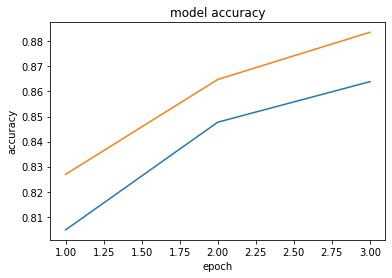

In [15]:
# simpleRNN과 GRU 비교 그래프
epochs1 = range(1, len(history1.history['accuracy']) + 1)
epochs2 = range(1, len(history2.history['accuracy']) + 1)
plt.plot(epochs1, history1.history['accuracy'])
plt.plot(epochs2, history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [18]:
dic = pd.read_json(direction + "/wordIndex.json")

# 이 부분분 실제제 상영중인 영화 리뷰들을 긁어와서 보강하면 될 듯
f = open(r'{}/eternals.txt'.format(direction))
testRev_raw = f.readline()
while testRev_raw:
    okt = Okt()
    testRev = okt.morphs(testRev_raw)
    testRev_idx = []
    words = list(dic['word'].values)
    indexs = list(dic['index'].values)
    for tok in testRev:
        if tok in words: testRev_idx.append(indexs[words.index(tok)])
    testRev_idx = np.array([testRev_idx])
    print('리뷰:', testRev_raw)
    print('(모델1) 긍정 리뷰일 확률:', model1.predict(testRev_idx))
    print('(모델2) 긍정 리뷰일 확률:', model2.predict(testRev_idx),'\n')
    testRev_raw = f.readline()

리뷰: 너무 캐릭터가 많아 산만하고, 마블에 큰 관심이 없다면 더욱 집중이 어려웠습니다.

(모델1) 긍정 리뷰일 확률: [[0.69914776]]
(모델2) 긍정 리뷰일 확률: [[0.3488332]] 

리뷰: 재미있음 ㅇㅇ 꿀잼

(모델1) 긍정 리뷰일 확률: [[0.9698963]]
(모델2) 긍정 리뷰일 확률: [[0.6638983]] 

리뷰: 뭔가 색다른 마블 영화. 속편은 어떨까

(모델1) 긍정 리뷰일 확률: [[0.4188113]]
(모델2) 긍정 리뷰일 확률: [[0.3844637]] 

리뷰: 마블 최고의 영화였다 앞으로도 마블의 톤이 이 영화같았으면 좋겠다

(모델1) 긍정 리뷰일 확률: [[0.9719333]]
(모델2) 긍정 리뷰일 확률: [[0.6173091]] 

리뷰: 이터널스들이 너무 약하고, 캐릭터성이 떨어짐.히어로 영화에 캐릭터들이 매력적이 않으면 무슨 재미로 보나..

(모델1) 긍정 리뷰일 확률: [[0.17960325]]
(모델2) 긍정 리뷰일 확률: [[0.31107438]] 

리뷰: 재밌었다

(모델1) 긍정 리뷰일 확률: [[0.9347912]]
(모델2) 긍정 리뷰일 확률: [[0.54699135]] 

리뷰: 애들쓰셨습니다... 안타깝습니다...

(모델1) 긍정 리뷰일 확률: [[0.19805446]]
(모델2) 긍정 리뷰일 확률: [[0.2390512]] 

리뷰: 액션은 크게 없으며 개인적으론 재미도 별로였습니다.

(모델1) 긍정 리뷰일 확률: [[0.23047522]]
(모델2) 긍정 리뷰일 확률: [[0.03574848]] 

리뷰: 영화관가서 두번이나 졸은 영화는 처음입니다.

(모델1) 긍정 리뷰일 확률: [[0.14625108]]
(모델2) 긍정 리뷰일 확률: [[0.21921617]] 

리뷰: 한번 쯤은 무조건 봐야된다고 생각할 정도로 재미있습니다.

(모델1) 긍정 리뷰일 확률: [[0.9575404]]
(모델2) 긍정 리뷰일 확률: [[0.8035525]] 

